In [1]:
import gzip
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO

In [2]:
cache_dir = 'caches/cache_11_14_big'
with gzip.GzipFile(os.path.join(cache_dir, 
        'extended_stroke_library_intensities.npy'),'r') as f:
    strokes = np.load(f).astype(np.float32)/255.
trajectories = np.load(os.path.join(cache_dir, 
        'extended_stroke_library_trajectories.npy'), 
        allow_pickle=True, encoding='bytes') 

strokes = torch.from_numpy(strokes).float().nan_to_num()
trajectories = torch.from_numpy(trajectories.astype(np.float32)).float().nan_to_num()

n = len(strokes)

# scale_factor = opt.max_height / strokes.shape[1]
stroke_shape = np.load(os.path.join(cache_dir, 'stroke_size.npy'))
h, w = stroke_shape[0], stroke_shape[1]
# strokes = transforms.Resize((int(strokes.shape[1]*scale_factor), int(strokes.shape[2]*scale_factor)))(strokes)
strokes = transforms.Resize((h,w))(strokes)

hs, he = int(.4*h), int(0.6*h)
ws, we = int(0.45*w), int(0.75*w)
strokes = strokes[:, hs:he, ws:we]

C:\Users\Ldori\miniconda3\envs\frida\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
def trajectory_to_points(trajectory, k):
    # trajectory: [x0, y0, z0, alpha0, x1, y1, z1, alpha1, ..., x3, y3, z3, alpha3]
    # xs and ys represent a cubic bezier curve
    # zs are to be interpolated linearly
    # alphas are assumed to be constant for now
    # returns length k list of [x,y,z,alpha] points tracing the trajectory
    
    assert k >= 2
    
    path = np.reshape(trajectory, (4, 4))
    
    res = []
    for i in range(k):
        t = i/(k-1)
        
        # Compute (x,y)
        x = (1-t)**3 * path[0][0] \
            + 3*(1-t)**2*t*path[1][0] \
            + 3*(1-t)*t**2*path[2][0] \
            + t**3*path[3][0]
        y = (1-t)**3 * path[0][1] \
            + 3*(1-t)**2*t*path[1][1] \
            + 3*(1-t)*t**2*path[2][1] \
            + t**3*path[3][1]
        
        # Compute z
        if t < 0.333:
            z = (1 - t/.333) * path[0][2] + (t/.333)*path[1][2]
        elif t < 0.666:
            z = (1 - (t-.333)/.333) * path[1][2] + ((t-.333)/.333)*path[2][2]
        else:
            z = (1 - (t-.666)/.333) * path[2][2] + ((t-.666)/.333)*path[3][2]
        
        # Compute alpha
        alpha = path[0][3]
        
        res.append([x, y, z, alpha])
    res = np.array(res)
    return res

def visualize_points(points):
    fig, ax = plt.subplots()
    plt.xlim([-0.01, 0.1])
    plt.ylim([-0.03, 0.03])
    ax.set_aspect('equal', adjustable='box')
    lines = []
    for i, (x,y,z,alpha) in enumerate(points):
        ax.add_patch(plt.Circle((x, y), z/400))
        if i != len(points)-1:
            lines.append([(x,y),(points[i+1][0], points[i+1][1])])
            lc = mc.LineCollection(lines, linewidth=0.1, antialiaseds=False)
            ax.add_collection(lc)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    return img

In [4]:
print(strokes.shape)
idx = 9
#plt.imshow(strokes[idx])
points = trajectory_to_points(trajectories[idx], 8)
print(points.shape)
png = visualize_points(points)

torch.Size([165, 409, 783])
(8, 4)


In [5]:
points = []
for i in range(len(trajectories)):
    points.append(trajectory_to_points(trajectories[i], 8))
points = torch.Tensor(points)

C:\Users\Ldori\AppData\Local\Temp\ipykernel_11576\1421783745.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  points = torch.Tensor(points)


In [6]:
from StrokeTrajVAE import StrokeTrajVAE

In [7]:
model = StrokeTrajVAE()

In [8]:
from StrokeTrajDataset import StrokeTrajDataset

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

resize = torchvision.transforms.Resize((64, 64))
s = resize(strokes)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

model = StrokeTrajVAE()
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(s))
train = s[:train_test_split], points[:train_test_split]
test = s[train_test_split:], points[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeTrajDataset(*test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for (stroke,trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            stroke_dec = args[0][0][i].squeeze(0).cpu().detach().numpy()
            traj_dec = args[0][1][i].cpu().detach().numpy()
            decoder_outputs.append((stroke_dec, traj_dec))
            stroke = args[1][0][i].squeeze(0).cpu().detach().numpy()
            traj = args[1][1][i].cpu().detach().numpy()
            originals.append((stroke, traj))

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

for epoch in range(1500):
    total_loss = 0
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%100 == 99:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                stroke_dec = args[0][0][i].squeeze(0).cpu().detach().numpy()
                traj_dec = args[0][1][i].cpu().detach().numpy()
                stroke = args[1][0][i].squeeze(0).cpu().detach().numpy()
                traj = args[1][1][i].cpu().detach().numpy()

                plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
                plt.imsave(f"{output_dir}/{i}-original.png", stroke)
                visualize_points(traj_dec).save(f"{output_dir}/{i}-traj_decoded.png")
                visualize_points(traj).save(f"{output_dir}/{i}-traj_original.png")
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)

    if epoch%100 == 99:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            stroke_dec, traj_dec = decoded_list[i][0], decoded_list[i][1]
            stroke, traj = original_list[i][0], original_list[i][1]
            plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
            plt.imsave(f"{output_dir}/{i}-original.png", stroke)
            visualize_points(traj_dec).save(f"{output_dir}/{i}-traj_decoded.png")
            visualize_points(traj).save(f"{output_dir}/{i}-traj_original.png")
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

Epoch 0: Train loss=1.6987842321395874, Validation loss=1.6811885833740234
Epoch 1: Train loss=0.596542477607727, Validation loss=1.5764524936676025
Epoch 2: Train loss=0.36969250440597534, Validation loss=1.6509544849395752
Epoch 3: Train loss=0.24994111061096191, Validation loss=1.4126405715942383
Epoch 4: Train loss=0.21157269179821014, Validation loss=0.7939074635505676
Epoch 5: Train loss=0.19496344029903412, Validation loss=0.4657737612724304
Epoch 6: Train loss=0.20729169249534607, Validation loss=0.5297864079475403
Epoch 7: Train loss=0.18469998240470886, Validation loss=0.48705384135246277
Epoch 8: Train loss=0.16117262840270996, Validation loss=0.43301013112068176
Epoch 9: Train loss=0.2094324827194214, Validation loss=0.6274012923240662
Epoch 10: Train loss=0.16207590699195862, Validation loss=0.5145246982574463
Epoch 11: Train loss=0.13952688872814178, Validation loss=0.4819425940513611
Epoch 12: Train loss=0.140159472823143, Validation loss=0.5145806074142456
Epoch 13: Tra

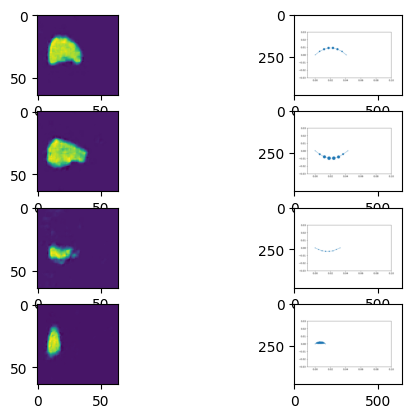

In [11]:
s, t = model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach().numpy())
    axs[i][1].imshow(visualize_points(t[i].cpu().detach().numpy()))